<hr style="border:0.1px solid gray">

# <center style='color:Red'> COSC2753 - Machine Learning </center> 
## <center style='color:Red'> Assignment 2 - Classify Images of Colon Cancer </center>

**Group Number:** 8

**Student 1:** Ngo Quang Khai - s3836387 

**Student 2:** Nguyen Quoc Minh - s3758994

**Student 3:** Bui Thanh Huy - s3740934

**Student 4:** Tran Vinh Khang - s3855823

**Student 5:** Le Trong Hung - s3805504

**Lecturer:** Dr. Bao Nguyen

**Due Date:** May 14th, 2021

<hr style="border:0.1px solid gray">

# Main Task

- **Task 1**: Classify images according to whether given cell image represents a cancerous cells or not (isCancerous)


- **Task 2**: Classify images according to cell-type, such as: fibroblast, inflammatory, epithelial or others.


- **Extra task**:

# 1. Import libraries and setting up environment

In [1]:
#!pip install tensorflow
#!pip install keras
#!pip install opencv-python
#!pip install imblearn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from tqdm import tqdm

import cv2
import os
import tensorflow as tf
import sklearn as sk

import warnings
warnings.filterwarnings('ignore')


#It is important to check the version of these libraries to make sure that implement the latest method.
print('Tensorflow version:', tf.__version__)
print('CV2 version:', cv2.__version__)

Tensorflow version: 2.8.0
CV2 version: 4.5.5


# 2. Import Dataset

In [3]:
#Import data_labels_mainData.csv into a DataFrame
main_data = pd.read_csv('data_labels_mainData.csv')

#Import data_labels_extraData.csv into a DataFrame
extra_data = pd.read_csv('data_labels_extraData.csv')

# 3. Exploratory Data Analysis (EDA)

## 3.1. Process the data

In [4]:
#See the data frame of main_data
print("Dataframe of main_data: \n", main_data, "\n")

#See the data frame of extra_data
print("Dataframe of extra_data: \n", extra_data)

Dataframe of main_data: 
       InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0          22405          1  22405.png   fibroblast         0            0
1          22406          1  22406.png   fibroblast         0            0
2          22407          1  22407.png   fibroblast         0            0
3          22408          1  22408.png   fibroblast         0            0
4          22409          1  22409.png   fibroblast         0            0
...          ...        ...        ...          ...       ...          ...
9891        1625         60   1625.png   epithelial         2            1
9892        1626         60   1626.png   epithelial         2            1
9893        1627         60   1627.png   epithelial         2            1
9894        1628         60   1628.png   epithelial         2            1
9895        1629         60   1629.png   epithelial         2            1

[9896 rows x 6 columns] 

Dataframe of extra_data: 
        InstanceID  p

Next, we will check if the data have any null values and datatype of each columns.

In [5]:
main_data.info()
main_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

In [6]:
extra_data.info()
extra_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10384 entries, 0 to 10383
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   10384 non-null  int64 
 1   patientID    10384 non-null  int64 
 2   ImageName    10384 non-null  object
 3   isCancerous  10384 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 324.6+ KB


InstanceID     0
patientID      0
ImageName      0
isCancerous    0
dtype: int64

**=>** Since our data is no missing/null value and properly formatted, we will move on to analyzing data.

Because we don't need columns InstanceID and patientID to train the models, so we are going to drop them.

In [7]:
#Drop 2 columns InstanceID and patientID for main_data
main_data = main_data.drop(['InstanceID', 'patientID'], axis='columns')

#Drop 2 columns InstanceID and patientID for extra_data
extra_data = extra_data.drop(['InstanceID', 'patientID'], axis='columns')

#See the dataframe of main_data and extra_data after drop 2 columns InstanceID and patientID
print("Dataframe of main_data after drop : \n", main_data, "\n")
print("Dataframe of extra_data after drop: \n", extra_data)

Dataframe of main_data after drop : 
       ImageName cellTypeName  cellType  isCancerous
0     22405.png   fibroblast         0            0
1     22406.png   fibroblast         0            0
2     22407.png   fibroblast         0            0
3     22408.png   fibroblast         0            0
4     22409.png   fibroblast         0            0
...         ...          ...       ...          ...
9891   1625.png   epithelial         2            1
9892   1626.png   epithelial         2            1
9893   1627.png   epithelial         2            1
9894   1628.png   epithelial         2            1
9895   1629.png   epithelial         2            1

[9896 rows x 4 columns] 

Dataframe of extra_data after drop: 
        ImageName  isCancerous
0      12681.png            0
1      12682.png            0
2      12683.png            0
3      12684.png            0
4      12685.png            0
...          ...          ...
10379  20028.png            0
10380  20029.png            0
103

## 3.2. Data Analysis and Visualiztion

Based on the information provided by the biomedical company as well as the DataFrames in **section 3.1** above. We are aware of:
- The **main_data** contains both **cellType (0 to 3)** and **isCancerous (0 and 1)** columns. In there, **cellType** values 0 to 3 represent fibroblast, inflammatory, epithelial, and miscellaneous cell types respectively based on the **cellTypeName** column. In addition, **isCancerous** values 0 and 1 represent colon cells with non-Cancer and Cancer.


- The **extra_data** only contains **isCancerous (0 and 1)** column.

**=>** Therefore, we choose the **isCancerous** attribute as the target column because both **main_data** and **extra_data** have the column **isCancerous**.

### 3.2.1. Data Distribution

### Countplot

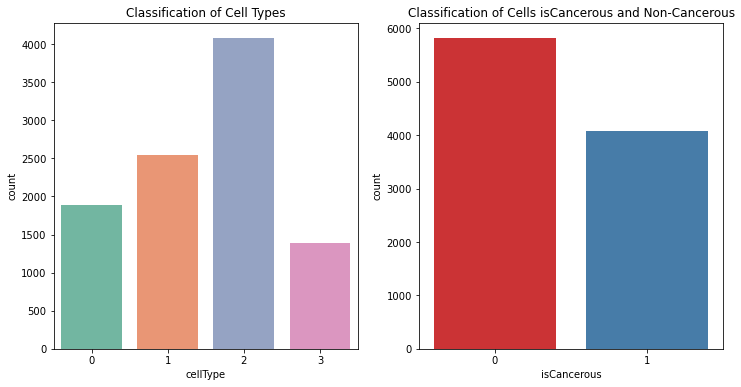

In [8]:
#Using the countplot to see the classification of cellType and isCancerous 
fig, ax =plt.subplots(1,2, figsize = (12,6))

# 0 = fibroblast, 1 = imflammatory, 2 = epithelial, 3 = others
sns.countplot(main_data['cellType'], palette='Set2', ax=ax[0]).set_title("Classification of Cell Types")

sns.countplot(main_data['isCancerous'], palette='Set1', ax=ax[1]).set_title("Classification of Cells isCancerous and Non-Cancerous")
fig.show()

**Analysis**
- The first countplot shows us there 4 different types of cell: 0, 1, 2, 3. The first type of cell is 0 has approximately 1900, the second type of cell is 2 has approximately 2600, the third one is 4100 and last one is 1500.


- The second countplot shows us number of cells that are cancer and not. In the first column is 0 represent the cell that are not cancerous, and 1 represent the cell that are cancerous. There are approximately 5900 cells that are not cancerous and 4200 cells that are cancerous in our data.

### Histogram

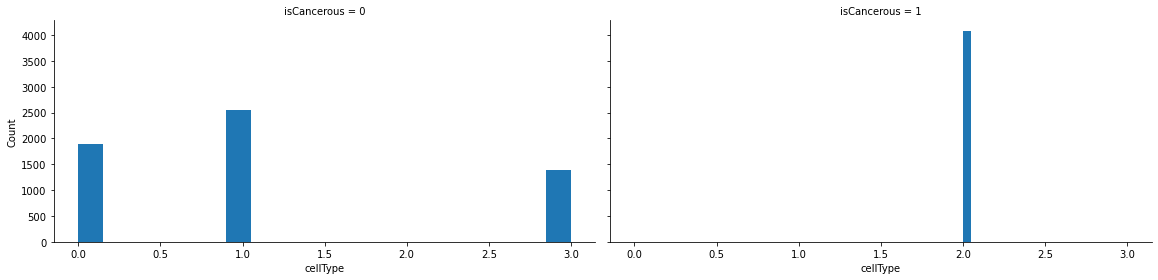

In [9]:
# Draw the histogram for cellType respected to isCancerous (class 0 and 1)
g = sns.FacetGrid(main_data, col='isCancerous', height=4, aspect=2)
g.map(plt.hist, str('cellType'), bins=20)
g.set_axis_labels('cellType', "Count")

**Analysis**

Looking at these two histograms, we can see that 'cellType' 0, 1, and 3 are not cancerous. Meanwhile only 'cellType' 2 is cancerous.

In [10]:
# Apply loc to double check that only cellType = 2 is Cancerous
main_data.loc[(main_data['cellType'] == 2) & (main_data['isCancerous'] == 1)]

,ImageName,cellTypeName,cellType,isCancerous
449,276.png,epithelial,2,1
450,277.png,epithelial,2,1
451,278.png,epithelial,2,1
452,279.png,epithelial,2,1
453,280.png,epithelial,2,1
...,...,...,...,...
9891,1625.png,epithelial,2,1
9892,1626.png,epithelial,2,1
9893,1627.png,epithelial,2,1
9894,1628.png,epithelial,2,1


### Conclusion

- In **main_data**, only the attribute **cellType** continue to be our strongest candidate for to influence our model when it has high impact on our target attribute is **isCancerous**.


- Attributes such as **InstanceID** and **patientID** might create a lot of noise in our model. 


- There are 4 types of cells: 0, 1, 2, 3. Only cell type number 2 is cancerous while others are not cancerous.


- We expect the the model would predict class 0 more accurately than class 1

## 3.3. Data Preparation

### 3.1 Split data into train and validation set

In [11]:
from sklearn.model_selection import train_test_split

#splitting data into train and validation 
train_task1, val_task1 = train_test_split(main_data[['ImageName', 'isCancerous']], 
                                              test_size=0.2, random_state=9)


train_task2, val_task2 = train_test_split(main_data[['ImageName','cellType']], 
                                              test_size=0.2, random_state=9)                                        

print('Training data shape task 1:', train_task1.shape)
print('Validation data shape task 1:', val_task1.shape)

print('Training data shape task 2:', train_task2.shape)
print('Validation data shape task 2:', val_task2.shape)

Training data shape task 1: (7916, 2)
Validation data shape task 1: (1980, 2)
Training data shape task 2: (7916, 2)
Validation data shape task 2: (1980, 2)


### 3.2. Create sample image to balance among classes (Oversampling Technique)

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)
#Create a a function to add image according to the name given from the list
from PIL import Image
def GetImage(training_dataset):
    images=[]
    unique = []
    for name in tqdm(training_dataset, desc="Adding images"):
        if name not in unique:
            image = cv2.imread("patch_images/"+name)
            image = Image.fromarray(image,'RGB')
            images.append(np.array(image))
            unique.append(name)
        else:
            image = cv2.imread("patch_images/"+name)
            image = Image.fromarray(image,'RGB')
            image = data_augmentation(image)
            images.append(np.array(image))

    result = np.array(images)
    print("\ngetImage COMPLETED!")
    return result

sai dòng 3 (directory) bởi vù nó chỉ muốn lấy data từ folder hình ảnh

In [13]:
#Create a function to generate sample to fix the Imblance of the dataset
from imblearn.over_sampling import RandomOverSampler
def GenerateSample(X,Y):
    ros = RandomOverSampler(random_state = 1)
    x, y = ros.fit_resample(X.values.reshape(-1,1), Y)
    x = x.flatten()
    return x,y

In [14]:
x1_train = train_task1['ImageName']
y1_train = train_task1['isCancerous']
print("Original Dataset:\n",y1_train.value_counts())

#Generate sample
x1_train, y1_train = GenerateSample(x1_train,y1_train)
print("Sampled Dataset:\n",y1_train.value_counts())
x1_train = GetImage(x1_train)

x1_test = val_task1['ImageName']
x1_test = GetImage(x1_test)

y1_test = val_task1['isCancerous']

Original Dataset:
 0    4634
1    3282
Name: isCancerous, dtype: int64
Sampled Dataset:
 0    4634
1    4634
Name: isCancerous, dtype: int64


Adding images:  83%|████████▎ | 7702/9268 [00:01<00:00, 3332.42it/s]

Adding images:  87%|████████▋ | 8036/9268 [00:03<00:01, 792.18it/s] 

Adding images:  89%|████████▉ | 8278/9268 [00:05<00:02, 348.71it/s]

Adding images:  91%|█████████ | 8451/9268 [00:06<00:03, 257.92it/s]

Adding images:  93%|█████████▎| 8576/9268 [00:07<00:03, 218.53it/s]

Adding images:  94%|█████████▎| 8667/9268 [00:08<00:03, 197.77it/s]

Adding images:  94%|█████████▍| 8735/9268 [00:08<00:02, 180.16it/s]

Adding images:  95%|█████████▍| 8786/9268 [00:09<00:02, 171.11it/s]

Adding images:  95%|█████████▌| 8826/9268 [00:09<00:02, 164.26it/s]

Adding images:  96%|█████████▌| 8858/9268 [00:09<00:02, 157.30it/s]

Adding images:  96%|█████████▌| 8884/9268 [00:10<00:02, 151.91it/s]

Adding images:  96%|█████████▌| 8906/9268 [00:10<00:02, 148.72it/s]

Adding images:  96%|█████████▋| 8925/9268 [00:10<00:02, 142.20it/s]

Adding images:  96%|█████████▋| 8942/9268 [00:10<00:02, 132.04it/s]

Adding images:  97%|█████████▋| 8957/9268 [00:10<00:02, 129.00it/s]

Adding images:  97%|█████████▋| 8971/9268 [00:10<00:02, 125.85it/s]

Adding images:  97%|█████████▋| 8984/9268 [00:11<00:02, 122.36it/s]

Adding images:  97%|█████████▋| 8997/9268 [00:11<00:02, 120.70it/s]

Adding images:  97%|█████████▋| 9011/9268 [00:11<00:02, 122.71it/s]

Adding images:  97%|█████████▋| 9024/9268 [00:11<00:01, 122.95it/s]

Adding images:  98%|█████████▊| 9037/9268 [00:11<00:01, 122.49it/s]

Adding images:  98%|█████████▊| 9051/9268 [00:11<00:01, 124.47it/s]

Adding images:  98%|█████████▊| 9064/9268 [00:11<00:01, 125.28it/s]

Adding images:  98%|█████████▊| 9077/9268 [00:11<00:01, 125.05it/s]

Adding images:  98%|█████████▊| 9090/9268 [00:11<00:01, 120.98it/s]

Adding images:  98%|█████████▊| 9103/9268 [00:12<00:01, 120.12it/s]

Adding images:  98%|█████████▊| 9116/9268 [00:12<00:01, 121.73it/s]

Adding images:  99%|█████████▊| 9129/9268 [00:12<00:01, 121.92it/s]

Adding images:  99%|█████████▊| 9142/9268 [00:12<00:01, 116.82it/s]

Adding images:  99%|█████████▉| 9154/9268 [00:12<00:01, 109.85it/s]

Adding images:  99%|█████████▉| 9167/9268 [00:12<00:00, 112.55it/s]

Adding images:  99%|█████████▉| 9179/9268 [00:12<00:00, 114.41it/s]

Adding images:  99%|█████████▉| 9191/9268 [00:12<00:00, 113.10it/s]

Adding images:  99%|█████████▉| 9203/9268 [00:12<00:00, 112.83it/s]

Adding images:  99%|█████████▉| 9216/9268 [00:12<00:00, 115.99it/s]

Adding images: 100%|█████████▉| 9228/9268 [00:13<00:00, 104.60it/s]

Adding images: 100%|█████████▉| 9239/9268 [00:13<00:00, 103.82it/s]

Adding images: 100%|█████████▉| 9252/9268 [00:13<00:00, 108.02it/s]

Adding images: 100%|█████████▉| 9264/9268 [00:13<00:00, 110.71it/s]

Adding images: 100%|██████████| 9268/9268 [00:13<00:00, 687.34it/s]



getImage COMPLETED!


Adding images: 100%|██████████| 1980/1980 [00:00<00:00, 5283.71it/s]


getImage COMPLETED!


In [15]:
x2_train = train_task2['ImageName']
y2_train = train_task2['cellType']
print("Original Dataset:\n",y2_train.value_counts())

#Generate sample
x2_train, y2_train = GenerateSample(x2_train,y2_train)
print("Sampled Dataset:\n",y2_train.value_counts())
x2_train = GetImage(x2_train)

x2_test = val_task2['ImageName']
x2_test = GetImage(x2_test)

y2_test = val_task2['cellType']

Original Dataset:
 2    3282
1    2036
0    1507
3    1091
Name: cellType, dtype: int64
Sampled Dataset:
 1    3282
3    3282
2    3282
0    3282
Name: cellType, dtype: int64


Adding images:  60%|█████▉    | 7837/13128 [00:01<00:01, 3249.08it/s]

Adding images:  62%|██████▏   | 8163/13128 [00:04<00:09, 499.17it/s] 

Adding images:  64%|██████▍   | 8396/13128 [00:05<00:16, 294.31it/s]

Adding images:  65%|██████▌   | 8563/13128 [00:07<00:20, 227.09it/s]

Adding images:  66%|██████▌   | 8683/13128 [00:08<00:22, 199.72it/s]

Adding images:  67%|██████▋   | 8771/13128 [00:09<00:24, 181.18it/s]

Adding images:  67%|██████▋   | 8836/13128 [00:09<00:24, 172.80it/s]

Adding images:  68%|██████▊   | 8886/13128 [00:10<00:25, 164.06it/s]

Adding images:  68%|██████▊   | 8925/13128 [00:10<00:26, 157.50it/s]

Adding images:  68%|██████▊   | 8956/13128 [00:10<00:27, 150.76it/s]

Adding images:  68%|██████▊   | 8981/13128 [00:10<00:28, 147.20it/s]

Adding images:  69%|██████▊   | 9003/13128 [00:11<00:30, 137.37it/s]

Adding images:  69%|██████▊   | 9021/13128 [00:11<00:30, 134.51it/s]

Adding images:  69%|██████▉   | 9037/13128 [00:11<00:30, 132.92it/s]

Adding images:  69%|██████▉   | 9052/13128 [00:11<00:30, 132.11it/s]

Adding images:  69%|██████▉   | 9067/13128 [00:11<00:31, 130.13it/s]

Adding images:  69%|██████▉   | 9081/13128 [00:11<00:30, 130.95it/s]

Adding images:  69%|██████▉   | 9095/13128 [00:11<00:30, 131.08it/s]

Adding images:  69%|██████▉   | 9109/13128 [00:11<00:31, 127.73it/s]

Adding images:  69%|██████▉   | 9122/13128 [00:12<00:32, 122.15it/s]

Adding images:  70%|██████▉   | 9135/13128 [00:12<00:32, 123.21it/s]

Adding images:  70%|██████▉   | 9148/13128 [00:12<00:32, 123.81it/s]

Adding images:  70%|██████▉   | 9161/13128 [00:12<00:31, 125.41it/s]

Adding images:  70%|██████▉   | 9174/13128 [00:12<00:31, 126.39it/s]

Adding images:  70%|██████▉   | 9187/13128 [00:12<00:32, 122.66it/s]

Adding images:  70%|███████   | 9200/13128 [00:12<00:31, 123.69it/s]

Adding images:  70%|███████   | 9213/13128 [00:12<00:31, 124.51it/s]

Adding images:  70%|███████   | 9226/13128 [00:12<00:32, 119.42it/s]

Adding images:  70%|███████   | 9239/13128 [00:13<00:33, 115.99it/s]

Adding images:  70%|███████   | 9251/13128 [00:13<00:34, 114.01it/s]

Adding images:  71%|███████   | 9263/13128 [00:13<00:33, 115.39it/s]

Adding images:  71%|███████   | 9275/13128 [00:13<00:34, 111.24it/s]

Adding images:  71%|███████   | 9287/13128 [00:13<00:35, 108.62it/s]

Adding images:  71%|███████   | 9301/13128 [00:13<00:33, 114.79it/s]

Adding images:  71%|███████   | 9314/13128 [00:13<00:32, 118.44it/s]

Adding images:  71%|███████   | 9327/13128 [00:13<00:31, 121.18it/s]

Adding images:  71%|███████   | 9340/13128 [00:13<00:31, 119.73it/s]

Adding images:  71%|███████   | 9353/13128 [00:14<00:33, 111.73it/s]

Adding images:  71%|███████▏  | 9365/13128 [00:14<00:35, 105.08it/s]

Adding images:  71%|███████▏  | 9376/13128 [00:14<00:35, 104.50it/s]

Adding images:  72%|███████▏  | 9389/13128 [00:14<00:33, 109.99it/s]

Adding images:  72%|███████▏  | 9401/13128 [00:14<00:33, 110.49it/s]

Adding images:  72%|███████▏  | 9413/13128 [00:14<00:34, 107.89it/s]

Adding images:  72%|███████▏  | 9426/13128 [00:14<00:33, 112.18it/s]

Adding images:  72%|███████▏  | 9438/13128 [00:14<00:32, 112.67it/s]

Adding images:  72%|███████▏  | 9450/13128 [00:14<00:34, 107.97it/s]

Adding images:  72%|███████▏  | 9461/13128 [00:15<00:33, 107.91it/s]

Adding images:  72%|███████▏  | 9472/13128 [00:15<00:33, 107.83it/s]

Adding images:  72%|███████▏  | 9483/13128 [00:15<00:33, 107.97it/s]

Adding images:  72%|███████▏  | 9496/13128 [00:15<00:32, 112.84it/s]

Adding images:  72%|███████▏  | 9510/13128 [00:15<00:30, 117.66it/s]

Adding images:  73%|███████▎  | 9522/13128 [00:15<00:30, 117.68it/s]

Adding images:  73%|███████▎  | 9535/13128 [00:15<00:29, 120.66it/s]

Adding images:  73%|███████▎  | 9548/13128 [00:15<00:30, 119.11it/s]

Adding images:  73%|███████▎  | 9560/13128 [00:15<00:31, 112.76it/s]

Adding images:  73%|███████▎  | 9572/13128 [00:15<00:31, 113.24it/s]

Adding images:  73%|███████▎  | 9584/13128 [00:16<00:31, 113.68it/s]

Adding images:  73%|███████▎  | 9596/13128 [00:16<00:31, 110.78it/s]

Adding images:  73%|███████▎  | 9609/13128 [00:16<00:30, 115.91it/s]

Adding images:  73%|███████▎  | 9622/13128 [00:16<00:29, 118.75it/s]

Adding images:  73%|███████▎  | 9635/13128 [00:16<00:29, 119.19it/s]

Adding images:  73%|███████▎  | 9648/13128 [00:16<00:28, 120.79it/s]

Adding images:  74%|███████▎  | 9661/13128 [00:16<00:28, 122.17it/s]

Adding images:  74%|███████▎  | 9674/13128 [00:16<00:28, 122.17it/s]

Adding images:  74%|███████▍  | 9687/13128 [00:16<00:29, 116.49it/s]

Adding images:  74%|███████▍  | 9699/13128 [00:17<00:29, 117.29it/s]

Adding images:  74%|███████▍  | 9711/13128 [00:17<00:29, 115.29it/s]

Adding images:  74%|███████▍  | 9723/13128 [00:17<00:29, 114.73it/s]

Adding images:  74%|███████▍  | 9736/13128 [00:17<00:28, 118.88it/s]

Adding images:  74%|███████▍  | 9748/13128 [00:17<00:28, 117.28it/s]

Adding images:  74%|███████▍  | 9761/13128 [00:17<00:28, 118.85it/s]

Adding images:  74%|███████▍  | 9774/13128 [00:17<00:28, 119.72it/s]

Adding images:  75%|███████▍  | 9787/13128 [00:17<00:27, 121.67it/s]

Adding images:  75%|███████▍  | 9800/13128 [00:17<00:27, 121.40it/s]

Adding images:  75%|███████▍  | 9813/13128 [00:18<00:27, 120.01it/s]

Adding images:  75%|███████▍  | 9826/13128 [00:18<00:27, 120.61it/s]

Adding images:  75%|███████▍  | 9839/13128 [00:18<00:26, 122.81it/s]

Adding images:  75%|███████▌  | 9852/13128 [00:18<00:26, 124.20it/s]

Adding images:  75%|███████▌  | 9865/13128 [00:18<00:26, 125.41it/s]

Adding images:  75%|███████▌  | 9878/13128 [00:18<00:26, 123.66it/s]

Adding images:  75%|███████▌  | 9891/13128 [00:18<00:26, 120.55it/s]

Adding images:  75%|███████▌  | 9904/13128 [00:18<00:26, 122.15it/s]

Adding images:  76%|███████▌  | 9917/13128 [00:18<00:26, 119.30it/s]

Adding images:  76%|███████▌  | 9929/13128 [00:18<00:27, 117.25it/s]

Adding images:  76%|███████▌  | 9941/13128 [00:19<00:27, 117.28it/s]

Adding images:  76%|███████▌  | 9953/13128 [00:19<00:27, 114.67it/s]

Adding images:  76%|███████▌  | 9966/13128 [00:19<00:26, 117.90it/s]

Adding images:  76%|███████▌  | 9978/13128 [00:19<00:27, 114.66it/s]

Adding images:  76%|███████▌  | 9991/13128 [00:19<00:26, 118.98it/s]

Adding images:  76%|███████▌  | 10005/13128 [00:19<00:25, 122.83it/s]

Adding images:  76%|███████▋  | 10018/13128 [00:19<00:25, 123.14it/s]

Adding images:  76%|███████▋  | 10032/13128 [00:19<00:24, 125.73it/s]

Adding images:  77%|███████▋  | 10045/13128 [00:19<00:25, 123.01it/s]

Adding images:  77%|███████▋  | 10058/13128 [00:20<00:24, 123.52it/s]

Adding images:  77%|███████▋  | 10071/13128 [00:20<00:24, 123.18it/s]

Adding images:  77%|███████▋  | 10085/13128 [00:20<00:24, 125.26it/s]

Adding images:  77%|███████▋  | 10099/13128 [00:20<00:23, 126.45it/s]

Adding images:  77%|███████▋  | 10112/13128 [00:20<00:24, 125.64it/s]

Adding images:  77%|███████▋  | 10125/13128 [00:20<00:24, 120.46it/s]

Adding images:  77%|███████▋  | 10139/13128 [00:20<00:24, 123.92it/s]

Adding images:  77%|███████▋  | 10152/13128 [00:20<00:23, 124.61it/s]

Adding images:  77%|███████▋  | 10165/13128 [00:20<00:24, 121.33it/s]

Adding images:  78%|███████▊  | 10178/13128 [00:21<00:25, 116.35it/s]

Adding images:  78%|███████▊  | 10190/13128 [00:21<00:25, 116.22it/s]

Adding images:  78%|███████▊  | 10203/13128 [00:21<00:24, 118.07it/s]

Adding images:  78%|███████▊  | 10216/13128 [00:21<00:24, 120.44it/s]

Adding images:  78%|███████▊  | 10229/13128 [00:21<00:23, 122.04it/s]

Adding images:  78%|███████▊  | 10242/13128 [00:21<00:23, 123.05it/s]

Adding images:  78%|███████▊  | 10255/13128 [00:21<00:23, 124.35it/s]

Adding images:  78%|███████▊  | 10268/13128 [00:21<00:22, 125.20it/s]

Adding images:  78%|███████▊  | 10281/13128 [00:21<00:23, 122.36it/s]

Adding images:  78%|███████▊  | 10294/13128 [00:21<00:23, 119.20it/s]

Adding images:  79%|███████▊  | 10306/13128 [00:22<00:24, 115.03it/s]

Adding images:  79%|███████▊  | 10319/13128 [00:22<00:23, 118.73it/s]

Adding images:  79%|███████▊  | 10331/13128 [00:22<00:23, 118.62it/s]

Adding images:  79%|███████▉  | 10343/13128 [00:22<00:23, 117.37it/s]

Adding images:  79%|███████▉  | 10356/13128 [00:22<00:23, 120.38it/s]

Adding images:  79%|███████▉  | 10369/13128 [00:22<00:23, 118.93it/s]

Adding images:  79%|███████▉  | 10382/13128 [00:22<00:22, 120.83it/s]

Adding images:  79%|███████▉  | 10395/13128 [00:22<00:22, 123.24it/s]

Adding images:  79%|███████▉  | 10408/13128 [00:22<00:22, 122.29it/s]

Adding images:  79%|███████▉  | 10421/13128 [00:23<00:22, 122.38it/s]

Adding images:  79%|███████▉  | 10434/13128 [00:23<00:22, 118.31it/s]

Adding images:  80%|███████▉  | 10447/13128 [00:23<00:22, 120.45it/s]

Adding images:  80%|███████▉  | 10460/13128 [00:23<00:21, 122.37it/s]

Adding images:  80%|███████▉  | 10473/13128 [00:23<00:21, 124.53it/s]

Adding images:  80%|███████▉  | 10486/13128 [00:23<00:21, 124.71it/s]

Adding images:  80%|███████▉  | 10499/13128 [00:23<00:20, 125.68it/s]

Adding images:  80%|████████  | 10512/13128 [00:23<00:20, 126.62it/s]

Adding images:  80%|████████  | 10525/13128 [00:23<00:21, 123.01it/s]

Adding images:  80%|████████  | 10538/13128 [00:23<00:21, 122.16it/s]

Adding images:  80%|████████  | 10551/13128 [00:24<00:21, 119.89it/s]

Adding images:  80%|████████  | 10564/13128 [00:24<00:22, 111.53it/s]

Adding images:  81%|████████  | 10576/13128 [00:24<00:23, 110.17it/s]

Adding images:  81%|████████  | 10588/13128 [00:24<00:22, 111.60it/s]

Adding images:  81%|████████  | 10600/13128 [00:24<00:24, 104.55it/s]

Adding images:  81%|████████  | 10612/13128 [00:24<00:23, 108.59it/s]

Adding images:  81%|████████  | 10625/13128 [00:24<00:22, 113.65it/s]

Adding images:  81%|████████  | 10637/13128 [00:24<00:21, 114.91it/s]

Adding images:  81%|████████  | 10649/13128 [00:24<00:21, 112.77it/s]

Adding images:  81%|████████  | 10661/13128 [00:25<00:21, 114.26it/s]

Adding images:  81%|████████▏ | 10673/13128 [00:25<00:21, 115.38it/s]

Adding images:  81%|████████▏ | 10686/13128 [00:25<00:20, 118.04it/s]

Adding images:  81%|████████▏ | 10699/13128 [00:25<00:20, 118.03it/s]

Adding images:  82%|████████▏ | 10712/13128 [00:25<00:20, 120.04it/s]

Adding images:  82%|████████▏ | 10725/13128 [00:25<00:19, 120.48it/s]

Adding images:  82%|████████▏ | 10738/13128 [00:25<00:19, 122.74it/s]

Adding images:  82%|████████▏ | 10751/13128 [00:25<00:19, 123.52it/s]

Adding images:  82%|████████▏ | 10764/13128 [00:25<00:19, 121.03it/s]

Adding images:  82%|████████▏ | 10777/13128 [00:26<00:20, 114.41it/s]

Adding images:  82%|████████▏ | 10789/13128 [00:26<00:20, 115.57it/s]

Adding images:  82%|████████▏ | 10802/13128 [00:26<00:19, 117.93it/s]

Adding images:  82%|████████▏ | 10815/13128 [00:26<00:19, 121.09it/s]

Adding images:  82%|████████▏ | 10828/13128 [00:26<00:18, 123.48it/s]

Adding images:  83%|████████▎ | 10841/13128 [00:26<00:18, 120.53it/s]

Adding images:  83%|████████▎ | 10855/13128 [00:26<00:18, 123.72it/s]

Adding images:  83%|████████▎ | 10868/13128 [00:26<00:18, 124.08it/s]

Adding images:  83%|████████▎ | 10881/13128 [00:26<00:18, 123.77it/s]

Adding images:  83%|████████▎ | 10894/13128 [00:27<00:18, 119.94it/s]

Adding images:  83%|████████▎ | 10907/13128 [00:27<00:18, 118.37it/s]

Adding images:  83%|████████▎ | 10920/13128 [00:27<00:18, 119.44it/s]

Adding images:  83%|████████▎ | 10933/13128 [00:27<00:18, 121.17it/s]

Adding images:  83%|████████▎ | 10946/13128 [00:27<00:18, 116.62it/s]

Adding images:  83%|████████▎ | 10959/13128 [00:27<00:18, 119.84it/s]

Adding images:  84%|████████▎ | 10972/13128 [00:27<00:18, 115.09it/s]

Adding images:  84%|████████▎ | 10985/13128 [00:27<00:18, 118.89it/s]

Adding images:  84%|████████▍ | 10997/13128 [00:27<00:18, 117.27it/s]

Adding images:  84%|████████▍ | 11009/13128 [00:28<00:18, 116.28it/s]

Adding images:  84%|████████▍ | 11021/13128 [00:28<00:18, 115.82it/s]

Adding images:  84%|████████▍ | 11034/13128 [00:28<00:17, 119.07it/s]

Adding images:  84%|████████▍ | 11047/13128 [00:28<00:17, 122.00it/s]

Adding images:  84%|████████▍ | 11060/13128 [00:28<00:16, 123.07it/s]

Adding images:  84%|████████▍ | 11073/13128 [00:28<00:16, 124.73it/s]

Adding images:  84%|████████▍ | 11086/13128 [00:28<00:16, 121.50it/s]

Adding images:  85%|████████▍ | 11099/13128 [00:28<00:17, 113.18it/s]

Adding images:  85%|████████▍ | 11111/13128 [00:28<00:18, 107.68it/s]

Adding images:  85%|████████▍ | 11123/13128 [00:28<00:18, 110.38it/s]

Adding images:  85%|████████▍ | 11136/13128 [00:29<00:17, 114.08it/s]

Adding images:  85%|████████▍ | 11148/13128 [00:29<00:17, 110.23it/s]

Adding images:  85%|████████▌ | 11160/13128 [00:29<00:18, 108.13it/s]

Adding images:  85%|████████▌ | 11172/13128 [00:29<00:17, 110.34it/s]

Adding images:  85%|████████▌ | 11184/13128 [00:29<00:17, 108.07it/s]

Adding images:  85%|████████▌ | 11197/13128 [00:29<00:17, 112.33it/s]

Adding images:  85%|████████▌ | 11209/13128 [00:29<00:17, 108.28it/s]

Adding images:  85%|████████▌ | 11221/13128 [00:29<00:17, 110.26it/s]

Adding images:  86%|████████▌ | 11233/13128 [00:29<00:17, 111.03it/s]

Adding images:  86%|████████▌ | 11245/13128 [00:30<00:16, 111.24it/s]

Adding images:  86%|████████▌ | 11258/13128 [00:30<00:16, 115.38it/s]

Adding images:  86%|████████▌ | 11270/13128 [00:30<00:16, 115.21it/s]

Adding images:  86%|████████▌ | 11282/13128 [00:30<00:15, 116.42it/s]

Adding images:  86%|████████▌ | 11294/13128 [00:30<00:15, 116.69it/s]

Adding images:  86%|████████▌ | 11306/13128 [00:30<00:16, 110.33it/s]

Adding images:  86%|████████▌ | 11318/13128 [00:30<00:16, 112.38it/s]

Adding images:  86%|████████▋ | 11330/13128 [00:30<00:15, 112.44it/s]

Adding images:  86%|████████▋ | 11342/13128 [00:30<00:16, 107.43it/s]

Adding images:  86%|████████▋ | 11354/13128 [00:31<00:16, 109.26it/s]

Adding images:  87%|████████▋ | 11367/13128 [00:31<00:15, 113.07it/s]

Adding images:  87%|████████▋ | 11379/13128 [00:31<00:15, 113.39it/s]

Adding images:  87%|████████▋ | 11392/13128 [00:31<00:14, 117.96it/s]

Adding images:  87%|████████▋ | 11405/13128 [00:31<00:14, 121.01it/s]

Adding images:  87%|████████▋ | 11418/13128 [00:31<00:13, 122.22it/s]

Adding images:  87%|████████▋ | 11431/13128 [00:31<00:13, 122.91it/s]

Adding images:  87%|████████▋ | 11444/13128 [00:31<00:13, 122.80it/s]

Adding images:  87%|████████▋ | 11457/13128 [00:31<00:13, 120.87it/s]

Adding images:  87%|████████▋ | 11470/13128 [00:32<00:14, 115.66it/s]

Adding images:  87%|████████▋ | 11483/13128 [00:32<00:13, 117.97it/s]

Adding images:  88%|████████▊ | 11495/13128 [00:32<00:14, 116.43it/s]

Adding images:  88%|████████▊ | 11508/13128 [00:32<00:13, 119.17it/s]

Adding images:  88%|████████▊ | 11521/13128 [00:32<00:13, 120.49it/s]

Adding images:  88%|████████▊ | 11535/13128 [00:32<00:12, 123.44it/s]

Adding images:  88%|████████▊ | 11548/13128 [00:32<00:13, 116.54it/s]

Adding images:  88%|████████▊ | 11560/13128 [00:32<00:13, 117.37it/s]

Adding images:  88%|████████▊ | 11573/13128 [00:32<00:13, 118.46it/s]

Adding images:  88%|████████▊ | 11585/13128 [00:33<00:13, 114.10it/s]

Adding images:  88%|████████▊ | 11597/13128 [00:33<00:13, 114.66it/s]

Adding images:  88%|████████▊ | 11609/13128 [00:33<00:13, 114.02it/s]

Adding images:  89%|████████▊ | 11622/13128 [00:33<00:12, 117.07it/s]

Adding images:  89%|████████▊ | 11635/13128 [00:33<00:12, 118.38it/s]

Adding images:  89%|████████▊ | 11647/13128 [00:33<00:12, 118.77it/s]

Adding images:  89%|████████▉ | 11660/13128 [00:33<00:12, 120.49it/s]

Adding images:  89%|████████▉ | 11673/13128 [00:33<00:11, 121.55it/s]

Adding images:  89%|████████▉ | 11686/13128 [00:33<00:11, 121.11it/s]

Adding images:  89%|████████▉ | 11699/13128 [00:33<00:11, 120.79it/s]

Adding images:  89%|████████▉ | 11712/13128 [00:34<00:11, 120.43it/s]

Adding images:  89%|████████▉ | 11725/13128 [00:34<00:11, 119.67it/s]

Adding images:  89%|████████▉ | 11738/13128 [00:34<00:11, 120.19it/s]

Adding images:  90%|████████▉ | 11751/13128 [00:34<00:11, 122.26it/s]

Adding images:  90%|████████▉ | 11764/13128 [00:34<00:11, 123.96it/s]

Adding images:  90%|████████▉ | 11777/13128 [00:34<00:11, 116.37it/s]

Adding images:  90%|████████▉ | 11789/13128 [00:34<00:11, 113.95it/s]

Adding images:  90%|████████▉ | 11801/13128 [00:34<00:11, 113.75it/s]

Adding images:  90%|████████▉ | 11813/13128 [00:34<00:12, 107.16it/s]

Adding images:  90%|█████████ | 11825/13128 [00:35<00:11, 110.35it/s]

Adding images:  90%|█████████ | 11837/13128 [00:35<00:11, 112.87it/s]

Adding images:  90%|█████████ | 11850/13128 [00:35<00:10, 117.72it/s]

Adding images:  90%|█████████ | 11863/13128 [00:35<00:10, 120.97it/s]

Adding images:  90%|█████████ | 11876/13128 [00:35<00:10, 121.90it/s]

Adding images:  91%|█████████ | 11889/13128 [00:35<00:10, 122.27it/s]

Adding images:  91%|█████████ | 11902/13128 [00:35<00:09, 122.95it/s]

Adding images:  91%|█████████ | 11915/13128 [00:35<00:09, 123.89it/s]

Adding images:  91%|█████████ | 11928/13128 [00:35<00:09, 123.65it/s]

Adding images:  91%|█████████ | 11941/13128 [00:35<00:09, 121.88it/s]

Adding images:  91%|█████████ | 11954/13128 [00:36<00:09, 120.68it/s]

Adding images:  91%|█████████ | 11967/13128 [00:36<00:09, 119.22it/s]

Adding images:  91%|█████████▏| 11980/13128 [00:36<00:09, 119.71it/s]

Adding images:  91%|█████████▏| 11993/13128 [00:36<00:09, 121.87it/s]

Adding images:  91%|█████████▏| 12006/13128 [00:36<00:09, 122.63it/s]

Adding images:  92%|█████████▏| 12019/13128 [00:36<00:09, 116.74it/s]

Adding images:  92%|█████████▏| 12031/13128 [00:36<00:09, 115.56it/s]

Adding images:  92%|█████████▏| 12044/13128 [00:36<00:09, 117.33it/s]

Adding images:  92%|█████████▏| 12056/13128 [00:36<00:09, 113.25it/s]

Adding images:  92%|█████████▏| 12068/13128 [00:37<00:09, 112.77it/s]

Adding images:  92%|█████████▏| 12081/13128 [00:37<00:09, 115.30it/s]

Adding images:  92%|█████████▏| 12094/13128 [00:37<00:08, 117.21it/s]

Adding images:  92%|█████████▏| 12107/13128 [00:37<00:08, 120.31it/s]

Adding images:  92%|█████████▏| 12120/13128 [00:37<00:08, 118.16it/s]

Adding images:  92%|█████████▏| 12132/13128 [00:37<00:08, 117.73it/s]

Adding images:  93%|█████████▎| 12144/13128 [00:37<00:08, 111.38it/s]

Adding images:  93%|█████████▎| 12156/13128 [00:37<00:08, 112.29it/s]

Adding images:  93%|█████████▎| 12168/13128 [00:37<00:08, 112.85it/s]

Adding images:  93%|█████████▎| 12180/13128 [00:38<00:08, 112.99it/s]

Adding images:  93%|█████████▎| 12192/13128 [00:38<00:08, 112.05it/s]

Adding images:  93%|█████████▎| 12204/13128 [00:38<00:08, 109.91it/s]

Adding images:  93%|█████████▎| 12216/13128 [00:38<00:08, 110.70it/s]

Adding images:  93%|█████████▎| 12229/13128 [00:38<00:07, 114.90it/s]

Adding images:  93%|█████████▎| 12241/13128 [00:38<00:07, 114.83it/s]

Adding images:  93%|█████████▎| 12253/13128 [00:38<00:07, 112.18it/s]

Adding images:  93%|█████████▎| 12265/13128 [00:38<00:07, 113.48it/s]

Adding images:  94%|█████████▎| 12277/13128 [00:38<00:07, 110.37it/s]

Adding images:  94%|█████████▎| 12289/13128 [00:39<00:07, 109.54it/s]

Adding images:  94%|█████████▎| 12301/13128 [00:39<00:07, 111.57it/s]

Adding images:  94%|█████████▍| 12313/13128 [00:39<00:07, 112.85it/s]

Adding images:  94%|█████████▍| 12325/13128 [00:39<00:07, 114.50it/s]

Adding images:  94%|█████████▍| 12337/13128 [00:39<00:07, 103.13it/s]

Adding images:  94%|█████████▍| 12351/13128 [00:39<00:07, 110.77it/s]

Adding images:  94%|█████████▍| 12364/13128 [00:39<00:06, 113.94it/s]

Adding images:  94%|█████████▍| 12376/13128 [00:39<00:06, 113.40it/s]

Adding images:  94%|█████████▍| 12388/13128 [00:39<00:06, 110.97it/s]

Adding images:  94%|█████████▍| 12401/13128 [00:40<00:06, 113.84it/s]

Adding images:  95%|█████████▍| 12413/13128 [00:40<00:06, 113.29it/s]

Adding images:  95%|█████████▍| 12425/13128 [00:40<00:06, 111.65it/s]

Adding images:  95%|█████████▍| 12437/13128 [00:40<00:06, 112.24it/s]

Adding images:  95%|█████████▍| 12450/13128 [00:40<00:05, 116.22it/s]

Adding images:  95%|█████████▍| 12462/13128 [00:40<00:05, 117.28it/s]

Adding images:  95%|█████████▌| 12474/13128 [00:40<00:05, 114.43it/s]

Adding images:  95%|█████████▌| 12487/13128 [00:40<00:05, 117.95it/s]

Adding images:  95%|█████████▌| 12499/13128 [00:40<00:05, 115.69it/s]

Adding images:  95%|█████████▌| 12511/13128 [00:41<00:05, 110.71it/s]

Adding images:  95%|█████████▌| 12523/13128 [00:41<00:05, 111.35it/s]

Adding images:  95%|█████████▌| 12535/13128 [00:41<00:05, 110.27it/s]

Adding images:  96%|█████████▌| 12547/13128 [00:41<00:05, 110.82it/s]

Adding images:  96%|█████████▌| 12560/13128 [00:41<00:04, 114.41it/s]

Adding images:  96%|█████████▌| 12572/13128 [00:41<00:04, 115.54it/s]

Adding images:  96%|█████████▌| 12585/13128 [00:41<00:04, 119.03it/s]

Adding images:  96%|█████████▌| 12597/13128 [00:41<00:04, 119.08it/s]

Adding images:  96%|█████████▌| 12609/13128 [00:41<00:04, 119.25it/s]

Adding images:  96%|█████████▌| 12621/13128 [00:41<00:04, 117.26it/s]

Adding images:  96%|█████████▌| 12633/13128 [00:42<00:04, 116.43it/s]

Adding images:  96%|█████████▋| 12646/13128 [00:42<00:04, 116.48it/s]

Adding images:  96%|█████████▋| 12658/13128 [00:42<00:04, 112.31it/s]

Adding images:  97%|█████████▋| 12671/13128 [00:42<00:03, 114.91it/s]

Adding images:  97%|█████████▋| 12684/13128 [00:42<00:03, 117.68it/s]

Adding images:  97%|█████████▋| 12697/13128 [00:42<00:03, 119.55it/s]

Adding images:  97%|█████████▋| 12709/13128 [00:42<00:03, 115.89it/s]

Adding images:  97%|█████████▋| 12722/13128 [00:42<00:03, 118.63it/s]

Adding images:  97%|█████████▋| 12734/13128 [00:42<00:03, 114.21it/s]

Adding images:  97%|█████████▋| 12746/13128 [00:43<00:03, 109.78it/s]

Adding images:  97%|█████████▋| 12759/13128 [00:43<00:03, 113.98it/s]

Adding images:  97%|█████████▋| 12771/13128 [00:43<00:03, 112.77it/s]

Adding images:  97%|█████████▋| 12784/13128 [00:43<00:02, 115.80it/s]

Adding images:  97%|█████████▋| 12797/13128 [00:43<00:02, 119.35it/s]

Adding images:  98%|█████████▊| 12810/13128 [00:43<00:02, 120.97it/s]

Adding images:  98%|█████████▊| 12823/13128 [00:43<00:02, 120.87it/s]

Adding images:  98%|█████████▊| 12836/13128 [00:43<00:02, 118.02it/s]

Adding images:  98%|█████████▊| 12848/13128 [00:43<00:02, 113.80it/s]

Adding images:  98%|█████████▊| 12860/13128 [00:44<00:02, 113.77it/s]

Adding images:  98%|█████████▊| 12872/13128 [00:44<00:02, 110.69it/s]

Adding images:  98%|█████████▊| 12884/13128 [00:44<00:02, 107.35it/s]

Adding images:  98%|█████████▊| 12897/13128 [00:44<00:02, 112.12it/s]

Adding images:  98%|█████████▊| 12910/13128 [00:44<00:01, 115.05it/s]

Adding images:  98%|█████████▊| 12923/13128 [00:44<00:01, 118.26it/s]

Adding images:  99%|█████████▊| 12935/13128 [00:44<00:01, 115.87it/s]

Adding images:  99%|█████████▊| 12947/13128 [00:44<00:01, 113.41it/s]

Adding images:  99%|█████████▊| 12960/13128 [00:44<00:01, 116.38it/s]

Adding images:  99%|█████████▉| 12972/13128 [00:45<00:01, 109.98it/s]

Adding images:  99%|█████████▉| 12984/13128 [00:45<00:01, 110.07it/s]

Adding images:  99%|█████████▉| 12996/13128 [00:45<00:01, 112.14it/s]

Adding images:  99%|█████████▉| 13008/13128 [00:45<00:01, 113.55it/s]

Adding images:  99%|█████████▉| 13020/13128 [00:45<00:00, 114.64it/s]

Adding images:  99%|█████████▉| 13033/13128 [00:45<00:00, 116.95it/s]

Adding images:  99%|█████████▉| 13045/13128 [00:45<00:00, 117.24it/s]

Adding images:  99%|█████████▉| 13057/13128 [00:45<00:00, 116.12it/s]

Adding images: 100%|█████████▉| 13070/13128 [00:45<00:00, 118.25it/s]

Adding images: 100%|█████████▉| 13083/13128 [00:45<00:00, 119.27it/s]

Adding images: 100%|█████████▉| 13095/13128 [00:46<00:00, 116.94it/s]

Adding images: 100%|█████████▉| 13107/13128 [00:46<00:00, 116.50it/s]

Adding images: 100%|█████████▉| 13119/13128 [00:46<00:00, 117.35it/s]

Adding images: 100%|██████████| 13128/13128 [00:46<00:00, 283.32it/s]


getImage COMPLETED!



Adding images: 100%|██████████| 1980/1980 [00:00<00:00, 5353.00it/s]


getImage COMPLETED!


In [16]:
print("TASK 1 SHAPE")
print("TRAIN SHAPE:")
print("x1 shape:", x1_train.shape)
print("y1 shape:", y1_train.shape)
print("TEST SHAPE:")
print("x1 shape:", x1_test.shape)
print("y1 shape:", y1_test.shape)

print("\n")

print("TASK 2 SHAPE")
print("x1 shape:", x1_train.shape)
print("y1 shape:", y1_train.shape)
print("TEST SHAPE:")
print("x1 shape:", x1_test.shape)
print("y1 shape:", y1_test.shape)

TASK 1 SHAPE
TRAIN SHAPE:
x1 shape: (9268, 27, 27, 3)
y1 shape: (9268,)
TEST SHAPE:
x1 shape: (1980, 27, 27, 3)
y1 shape: (1980,)


TASK 2 SHAPE
x1 shape: (9268, 27, 27, 3)
y1 shape: (9268,)
TEST SHAPE:
x1 shape: (1980, 27, 27, 3)
y1 shape: (1980,)


# 3.3. Data Augmentation Technique

Lý do dùng ??

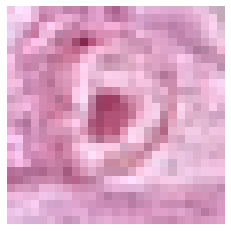

In [17]:
plt.axis('off')
plt.imshow(x1_train[2580].astype(np.uint8))

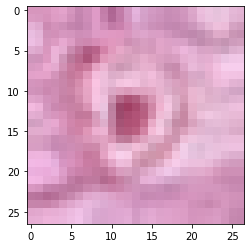

In [18]:
plt.imshow((x1_train)[7916].astype(np.uint8))

In [19]:
# Apply loc to double check that only cellType = 2 is Cancerous
#main_data.loc[(main_data['cellType'] == 2) & (main_data['isCancerous'] == 1)]

In [20]:
# Create datagen
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()

# train_datagen1 = datagen.flow(train_img_X1, train_mod_Y1, batch_size=16, shuffle=True)
data_train1 = datagen.flow(x1_train, y1_train, batch_size=16, shuffle=True)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D , Flatten, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2

In [22]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(27, 27, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, kernel_regularizer=l2(l=0.01), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, kernel_regularizer=l2(l=0.01), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                      

# non-stack model

32-64-128 Dense:512 Dropout

In [23]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(27, 27, 3)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2, 2)))
model1.add(Dropout(0.2))

model1.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2, 2)))
model1.add(Dropout(0.3))

model1.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2, 2)))
model1.add(Dropout(0.4))

model1.add(Flatten())
model1.add(Dense(512, kernel_regularizer=l2(l=0.01), activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(4, activation='softmax'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_8 (Batc  (None, 27, 27, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 13, 13, 64)      

In [24]:
model1.compile(optimizer='Adam' , loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.fit(data_train1, epochs=30 ,verbose=1)    
scores = model1.evaluate(x1_test, y1_test, verbose=1)

Epoch 1/30
580/580 [==============================] - 12s 19ms/step - loss: 5.4160 - accuracy: 0.8386
Epoch 2/30
580/580 [==============================] - 10s 17ms/step - loss: 1.2153 - accuracy: 0.8752
Epoch 3/30
580/580 [==============================] - 10s 17ms/step - loss: 0.5869 - accuracy: 0.8766
Epoch 4/30
580/580 [==============================] - 11s 20ms/step - loss: 0.5136 - accuracy: 0.8730
Epoch 5/30
580/580 [==============================] - 11s 19ms/step - loss: 0.4843 - accuracy: 0.8761
Epoch 6/30
580/580 [==============================] - 12s 21ms/step - loss: 0.4911 - accuracy: 0.8707
Epoch 7/30
580/580 [==============================] - 11s 19ms/step - loss: 0.4774 - accuracy: 0.8747
Epoch 8/30
580/580 [==============================] - 12s 20ms/step - loss: 0.4806 - accuracy: 0.8787
Epoch 9/30
580/580 [==============================] - 12s 21ms/step - loss: 0.4693 - accuracy: 0.8792
Epoch 10/30
580/580 [==============================] - 12s 20ms/step - loss: 0.474

32-64-128 Dense:512 No Dropout

In [25]:
model5 = Sequential()
model5.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(27, 27, 3)))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2, 2)))

model5.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2, 2)))

model5.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2, 2)))

model5.add(Flatten())
model5.add(Dense(512, kernel_regularizer=l2(l=0.01), activation='relu'))
model5.add(BatchNormalization())
model5.add(Dense(4, activation='softmax'))

model5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_12 (Bat  (None, 27, 27, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 13, 13, 64)       256       
 chNormalization)                                                
                                                      

In [ ]:
model5.compile(optimizer='Adam' , loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model5.fit(data_train1, epochs=30 ,verbose=1)    
scores = model5.evaluate(x1_test, y1_test, verbose=1)

Epoch 1/30
580/580 [==============================] - 10s 17ms/step - loss: 4.1553 - accuracy: 0.8512
Epoch 2/30
580/580 [==============================] - 11s 19ms/step - loss: 0.7620 - accuracy: 0.8692
Epoch 3/30
580/580 [==============================] - 11s 19ms/step - loss: 0.4633 - accuracy: 0.8731
Epoch 4/30
580/580 [==============================] - 12s 20ms/step - loss: 0.4036 - accuracy: 0.8735
Epoch 5/30
580/580 [==============================] - 11s 18ms/step - loss: 0.3924 - accuracy: 0.8763
Epoch 6/30
580/580 [==============================] - 11s 19ms/step - loss: 0.3984 - accuracy: 0.8793
Epoch 7/30
580/580 [==============================] - 11s 19ms/step - loss: 0.3809 - accuracy: 0.8851
Epoch 8/30
580/580 [==============================] - 11s 20ms/step - loss: 0.3704 - accuracy: 0.8775
Epoch 9/30
580/580 [==============================] - 10s 17ms/step - loss: 0.3791 - accuracy: 0.8845
Epoch 10/30
580/580 [==============================] - 10s 18ms/step - loss: 0.359

# Lower filter model

16-32-64 Dense: 256

In [ ]:
model3 = Sequential()
model3.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(27, 27, 3)))
model3.add(BatchNormalization())
model3.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model3.add(BatchNormalization())
model3.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.3))

model3.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model3.add(BatchNormalization())
model3.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.4))

model3.add(Flatten())
model3.add(Dense(256, kernel_regularizer=l2(l=0.01), activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))
model3.add(Dense(256, kernel_regularizer=l2(l=0.01), activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))
model3.add(Dense(4, activation='softmax'))

model3.summary()

In [ ]:
model3.compile(optimizer='Adam' , loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.fit(data_train1, epochs=30 ,verbose=1)    
scores = model3.evaluate(x1_test, y1_test, verbose=1)

32-64-128 Dense:256

In [ ]:
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(27, 27, 3)))
model4.add(BatchNormalization())
model4.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.2))

model4.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model4.add(BatchNormalization())
model4.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.3))

model4.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model4.add(BatchNormalization())
model4.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.4))

model4.add(Flatten())
model4.add(Dense(256, kernel_regularizer=l2(l=0.01), activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
model4.add(Dense(256, kernel_regularizer=l2(l=0.01), activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
model4.add(Dense(4, activation='softmax'))

model4.summary()

In [ ]:
model4.compile(optimizer='Adam' , loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model4.fit(data_train1, epochs=30 ,verbose=1)    
scores = model4.evaluate(x1_test, y1_test, verbose=1)

16-32-64 Dense: 512

In [ ]:
model2 = Sequential()
model2.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(27, 27, 3)))
model2.add(BatchNormalization())
model2.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.3))

model2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.4))

model2.add(Flatten())
model2.add(Dense(512, kernel_regularizer=l2(l=0.01), activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(512, kernel_regularizer=l2(l=0.01), activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(4, activation='softmax'))

model2.summary()

In [ ]:
model2.compile(optimizer='Adam' , loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.fit(data_train1, epochs=30 ,verbose=1)    
scores = model2.evaluate(x1_test, y1_test, verbose=1)

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0005, beta_1=0.4, beta_2=0.444, decay=1.0e-6, amsgrad=True)
model.compile(optimizer=opt , loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early = EarlyStopping(monitor='accuracy', min_delta=0.001, patience=10, verbose=1, mode='auto')
#reduce learning rate when the metric is not improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-15) 

EPOCHS = 50
BATCH_SIZE = 32

import time
start_time = time.time()

history = model.fit(data_train1, 
                    validation_data=(x1_test, y1_test), 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=1,
                    callbacks=[reduce_lr, early])

print("---  Training time in seconds ---%s " % (time.time() - start_time))

In [ ]:
model.save("task1_10.5.2022")

In [ ]:
scores = model.evaluate(x1_test, y1_test, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])
print('Max Validation accuracy:', max(history.history['accuracy']))

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
predict=model.predict(x1_test)
classes=np.argmax(predict,axis=1)

print(classification_report(y1_test, classes))


In [ ]:
for i, image in enumerate(x1_test):
     plt.imshow(image) 
for i in range (20):
    plt.imshow(x1_test[i])
    plt.title("GT-{}, Pred-{}".format(y1_test.tolist()[i], classes[i] ))
    plt.show()

In [ ]:
predict=model.predict(x1_test)
classes=np.argmax(predict,axis=1)

print(classification_report(y1_test, classes))
